In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 65.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=16cc4a0fea9b6df51cb9ed3766034fbc3f493edec97f669bac9ef075ce94acd0
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=35c5efbe77a9ae592c2de80895d56713a41d3297e42a35e2c15589b3a2b4b54e
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [5]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

from pathlib import Path
import torch
from torch import nn, optim

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F

import segmentation_models_pytorch as smp

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [8]:
DATASET_FILEPATH = Path('../input/makeup-lips-segmentation-28k-samples/set-lipstick-original')
IMAGES = '720p'  #директория в которой хранятся изображения
MASKS = 'mask'  #директория в которой хранятся маски
LIST_CSV = 'list.csv' # инфо

IMAGES_FILEPATH = DATASET_FILEPATH.joinpath(IMAGES)
MASKS_FILEPATH = DATASET_FILEPATH.joinpath(MASKS)
LIST_CSV_FILEPATH = DATASET_FILEPATH.joinpath(LIST_CSV)

df_lips_images = pd.read_csv(LIST_CSV_FILEPATH)
df_lips_images.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [9]:
feats = ['filename', 'mask']
df_lips_images = df_lips_images[feats]
df_lips_images.head()

,filename,mask
0,image00000001.jpg,mask00000001.png
1,image00000002.jpg,mask00000002.png
2,image00000003.jpg,mask00000003.png
3,image00000004.jpg,mask00000004.png
4,image00000005.jpg,mask00000005.png


In [10]:
df_lips_images.isna().sum()

filename    0
mask        0
dtype: int64

In [11]:
list_of_an_images = sorted([i for i in Path(IMAGES_FILEPATH).iterdir()])
list_of_a_masks = sorted([i for i in Path(MASKS_FILEPATH).iterdir()])

len(list_of_an_images), len(list_of_a_masks)

(28594, 28540)

In [12]:
df_lips_images = df_lips_images.loc[df_lips_images['mask'].isin([i.name for i in list_of_a_masks])]
df_lips_images.reset_index(drop=True, inplace=True)
df_lips_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28540 non-null  object
 1   mask      28540 non-null  object
dtypes: object(2)
memory usage: 446.1+ KB


In [14]:
IMG_SIZE = 256

def resize_an_image_and_mask(image_filename, mask_filename, new_size):
    image = cv2.imread(str(IMAGES_FILEPATH.joinpath(image_filename)))
    mask = cv2.imread(str(MASKS_FILEPATH.joinpath(mask_filename)))
    resized_image = cv2.cvtColor(cv2.resize(image, (new_size, new_size)), cv2.COLOR_BGR2RGB)
    resized_mask = cv2.cvtColor(cv2.resize(mask, (new_size, new_size)), cv2.COLOR_BGR2RGB)
    
    return resized_image, resized_mask

class LipsDataset(torch.utils.data.Dataset):
    def __init__(self, data, preprocessing=None):
        self.data = data
        self.preprocessing = preprocessing
        self.images_paths = self.data.iloc[:, 0]
        self.masks_paths = self.data.iloc[:, 1]
        self.data_len = len(self.data.index)
        
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        img_path = self.images_paths[idx]
        mask_path = self.masks_paths[idx]
        img, mask = resize_an_image_and_mask(img_path, mask_path, IMG_SIZE)
        img = img.astype(float)
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            img = torch.as_tensor(img)
            img /= 255.0
        
        img = img.permute(2, 0, 1)
        cls_mask_1 = mask[..., 1]
        cls_mask_1 = np.where(mask > 50, 1, 0)[:,:,1]
        cls_mask_1 = cls_mask_1.astype('float')
        masks = [cls_mask_1]
        masks = torch.as_tensor(masks, dtype=torch.float)
        
        return img.float(), masks

In [15]:
BACKBONE = 'efficientnet-b1'

segmodel = smp.PAN(encoder_name=BACKBONE, classes=1, activation='sigmoid')
segmodel.to(device)

preprocess_input = smp.encoders.get_preprocessing_fn(encoder_name=BACKBONE, pretrained='imagenet')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 284MB/s]


In [17]:
X_train, X_valid = train_test_split(df_lips_images, test_size=0.25,random_state=14)

X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)

train_data = LipsDataset(X_train, preprocessing=preprocess_input)
valid_data = LipsDataset(X_valid, preprocessing=preprocess_input)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=30, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=30, shuffle=True)

In [19]:
for imgs, masks in train_loader:
    print(imgs.shape)
    print(masks.shape)
    print(masks.min(), masks.max())
    break

torch.Size([30, 3, 256, 256])
torch.Size([30, 1, 256, 256])
tensor(0.) tensor(1.)


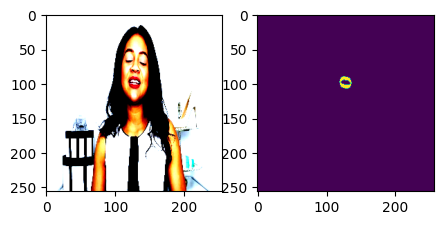

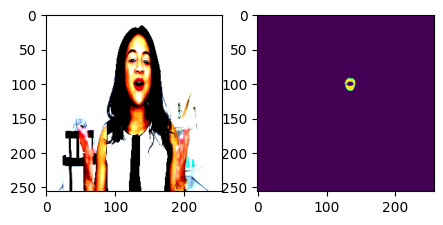

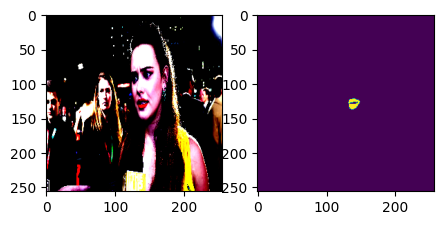

In [20]:

for i, (imgs, masks) in enumerate(train_loader):
    fig, ax = plt.subplots(1, 2, figsize=(5, 5))
    ax[0].imshow(imgs[0].permute(1, 2, 0))
    ax[1].imshow(masks[0].permute(1, 2, 0))
    if i == 2:
        break

In [21]:
from segmentation_models_pytorch import utils as smp_utils

criterion = smp_utils.losses.BCELoss()
metrics = [smp_utils.metrics.IoU(), ]
optimizer = optim.NAdam(segmodel.parameters(), lr=0.001)

train_epoch = smp_utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True
)

valid_epoch = smp_utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics,
    device=device,
    verbose=True
)

In [23]:
max_score = 0.7

for i in range(0, 1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    
    if max_score < valid_logs['iou_score']:
        #max_score = valid_logs['iou_score']
        torch.save(segmodel, './model.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|██████████| 238/238 [05:31<00:00,  1.39s/it, bce_loss - 0.001478, iou_score - 0.881] 
Model saved!
